AR composites (both anomaly/non-anomaly) of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates a 9 panel plot with the following variables in the columns
1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (ivt) 
3. (precip)


## Imports

In [2]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from timeseries import persistence
from statistical_tests import independent_ttest
import nclcmaps as nclc

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/composites/'      # figures


In [4]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_anom']
plot_dict_ivt = config['ivt_anom']
plot_dict_prec = config['precip_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config['djf']

### ERA5 renalysis

In [6]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []
# # Select lat/lon grid
# lonmin = plot_dicts[1]['bnds'][0]
# lonmax = plot_dicts[1]['bnds'][1]
# latmin = plot_dicts[1]['bnds'][2]
# latmax = plot_dicts[1]['bnds'][3]

# Select lat/lon grid
lonmin = 40
lonmax = 120
latmin = 10
latmax = 50

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))


In [7]:
var_dict = {'H': (['time', 'lat', 'lon'], (f[0]['z'].values/(9.80665))), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values)}


ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 7.62



### AR days

In [8]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ar_dict['ssn'] + '.csv'

# # test neofs: 2, 3, 4
# neofs = 3
# # test nk: 2, 4
# nk = 4
# filepath = path_to_out + fname_id + 'hma_AR-types-' + ar_dict['ssn'] + 'neof_' + str(neofs) + '_nk' + str(nk) + '.csv'
df = pd.read_csv(filepath)


In [9]:
# Trim date range
idx = slice(ar_dict['start_date'], ar_dict['end_date'])
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Select DJF months
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

ds2['ar'] = ('time', df.AR_CAT)
ds2 = ds2.set_coords('ar')

In [10]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

In [11]:
# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)

# Lag=0, -2, +2
era_ar_lag02 = select_ar_days(era=ds2, lag=0)
era_ar_lag22 = select_ar_days(era=ds2, lag=-2)


# combine lag datasets into 1 ds object
era_ar_lag = xr.concat([era_ar_lag0, era_ar_lag2], pd.Index([0, 2], name='lag'))
era_ar_lag2 = xr.concat([era_ar_lag02, era_ar_lag22], pd.Index([0, 2], name='lag'))

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 161, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 12.0 11.5 11.0 10.5 10.0
  * lon      (lon) float32 40.0 40.5 41.0 41.5 42.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 2 3 3 1 3 3 3 1 2 3 3 ... 3 3 3 3 3 3 3 2 2 1 1 1
Data variables:
    H        (time, lat, lon) float64 -239.7 -248.3 -256.5 ... -8.103 -7.236
    U        (time, lat, lon) float64 0.3743 -0.5254 -1.247 ... 2.982 2.978
    V        (time, lat, lon) float64 -15.88 -15.72 -15.53 ... 3.627 4.455 4.504
    ivte     (time, lat, lon) float64 1.252 -5.277 -11.4 ... -138.8 -130.0
    ivtn     (time, lat, lon) float64 -86.53 -85.33 -83.81 ... 94.3 91.69 91.34
<xarray.Dataset>
Dimensions:  (lat: 81, lon: 161, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 4

### Compute AR Composites

In [12]:
# Count number of independent AR events
x = ds.ar
event_id, nevents, duration = persistence(x)
print('Total number of AR days in season: ', x.count().values)
print('Total number of independent AR events: ', nevents)

Total number of AR days in season:  3520
Total number of independent AR events:  69


In [18]:
def create_list_all_dates(start_date, end_date, date_lst):    
    # date array with all days
    dates_allDays = pd.date_range(start=start_date, end=end_date, freq='1D')
    arr_allDays = np.zeros(len(dates_allDays), dtype=np.float)

    # Loop over ar days and match to ar_full 
    for i, date in enumerate(date_lst):
        idx = np.where(dates_allDays == date)
        arr_allDays[idx] = 1
    
    return arr_allDays

In [19]:
nevents_lst = []
for i in np.arange(1, 4, 1):    
    idx = (ds['ar'] == i)
    tmp = ds.sel(time=idx)

    # make time series of [0, 1, 0, 0] for dates where conditions are met
    date_lst = tmp.time.values
    df_tmp = create_list_all_dates('1979-12-01 09:00', '2018-02-28 09:00', date_lst)
    df_tmp

    # calculate number of independent events
    event_id, nevents, duration = persistence(df_tmp)
    nevents_lst.append(nevents)

In [20]:
nevents_lst

[70, 73, 90]

In [13]:
era_ar_lag

<xarray.Dataset>
Dimensions:  (lag: 2, lat: 81, lon: 161, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 12.0 11.5 11.0 10.5 10.0
  * lon      (lon) float32 40.0 40.5 41.0 41.5 42.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 2 3 3 1 3 3 3 1 2 3 3 ... 3 3 3 3 3 3 3 2 2 1 1 1
  * lag      (lag) int64 0 2
Data variables:
    H        (lag, time, lat, lon) float64 -239.7 -248.3 -256.5 ... 1.729 1.727
    U        (lag, time, lat, lon) float64 0.3743 -0.5254 -1.247 ... 2.168 2.373
    V        (lag, time, lat, lon) float64 -15.88 -15.72 -15.53 ... 3.08 2.737
    ivte     (lag, time, lat, lon) float64 1.252 -5.277 -11.4 ... 36.6 36.32
    ivtn     (lag, time, lat, lon) float64 -86.53 -85.33 -83.81 ... 12.94 17.59

In [27]:
from scipy.stats import ttest_1samp, t, pearsonr, norm, linregress
import scipy.stats.distributions as dist

def ttest_1samp_lag(sample_obs, popmean):
    '''Wrapped stats.ttest_1samp to iterate ttest over sample in xr.dataset form
       The dataset should have coords ['time', 'lat', 'lon', 'lag']
       This variation is used specifically to run ttest for multiple vars and multiple lags
       
    Parameters
    ----------
    sample_obs : xarray ds
        grouped xarray ds object
    popmean: array_like, zeros
        array of repeating zeros that matches the dimensions of the sample_obs
        
    Returns
    -------
    tvalue : array_like, float
        xarray ds object with same vars as sample_obs that has the tvalue for the one-sample t-test
    pvalue : array_like, float
        xarray ds object with same vars as sample_obs that has the pvalue for the one-sample t-test 
    
    Example
    -------
    Given:
        sample_obs          = ds.groupby('time.season')
    Returns:
        tvalue   = ds_tvalue
        pvalue   = ds_pvalue
        
    '''
    return xr.apply_ufunc(ttest_1samp,
                          sample_obs,
                          input_core_dims=[['lag', 'time']],
                          dask='allowed', output_core_dims=[['lag'], ['lag']],
                          kwargs={'popmean': popmean, 'axis': -1, 'nan_policy': 'omit'})

def independent_ttest(ds, group, alpha, n):
    '''Calculate statistical significance using 1-sample t-test of ds with lag coord
    and create mask of ds where values are considered significant'''
    nlat = len(ds.lat)
    nlon = len(ds.lon)
    nlag = len(ds.lag)
    # calculate t-statistic and p-value
    tval, pval = ttest_1samp_lag(ds.groupby(group), popmean=np.zeros([nlat, nlon, nlag]))
    # calculate the critical value
    df = n-2
    cv = t.ppf(1.0 - alpha, df)
    print('Critical t-value: ', cv)
    # interpret via critical value
    # if abs(tvalue) >= cv, reject null hypothesis that the means are equal
    maskt_idx = (abs(tval) >= cv)
    
#     # find p-value based on tval and nprime (rather than n)
#     pval = t.sf(np.abs(tval), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
#     # interpret via p-value
#     # if p < alpha, reject null hypothesis that the means are equal
#     maskp_idx = (pval < alpha)
    return maskt_idx

In [28]:
# Compute composites of each AR type
era_ar_comp = era_ar_lag.groupby('ar').mean('time')
era_ar_comp1 = era_ar_lag2.groupby('ar').mean('time')

# run 1-sample t-test, mask results below 95% confidence level
if plot_dict['anom'] == 'anom':
    tval_mask = independent_ttest(ds=era_ar_lag, group='ar', alpha=0.05, n=70)
    era_ar_comp = era_ar_comp.where(tval_mask == True)
    
    tval_mask = independent_ttest(ds=era_ar_lag2, group='ar', alpha=0.05, n=70)
    era_ar_comp1 = era_ar_comp1.where(tval_mask == True)
else:
    era_ar_comp = era_ar_comp
    era_ar_comp1 = era_ar_comp1


Critical t-value:  1.6675722806611726
Critical t-value:  1.6675722806611726


In [29]:
tval_mask

<xarray.Dataset>
Dimensions:  (ar: 3, lag: 2, lat: 161, lon: 321)
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
  * lag      (lag) int64 0 2
  * ar       (ar) int64 1 2 3
Data variables:
    prec     (ar, lat, lon, lag) bool False False False ... True False True

### Figures

### Common Plot Properties

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 3,
            'artype_lst': [3, 1, 2],
            'panel': '9pan'}

# # test plot    
# panel_test = {'nrows': nk,
#             'ncols': 3,
#             'artype_lst': list(range(1, nk+1)),
#             'panel': 'test'+str(neofs)+str(nk)}


panel_dict = panel_9

### Composite Plots

-7.292255759239197e-06 19.782628566026688
-7.031033340009671e-06 26.13939803491518
-1.862645149230957e-06 31.387943029403687


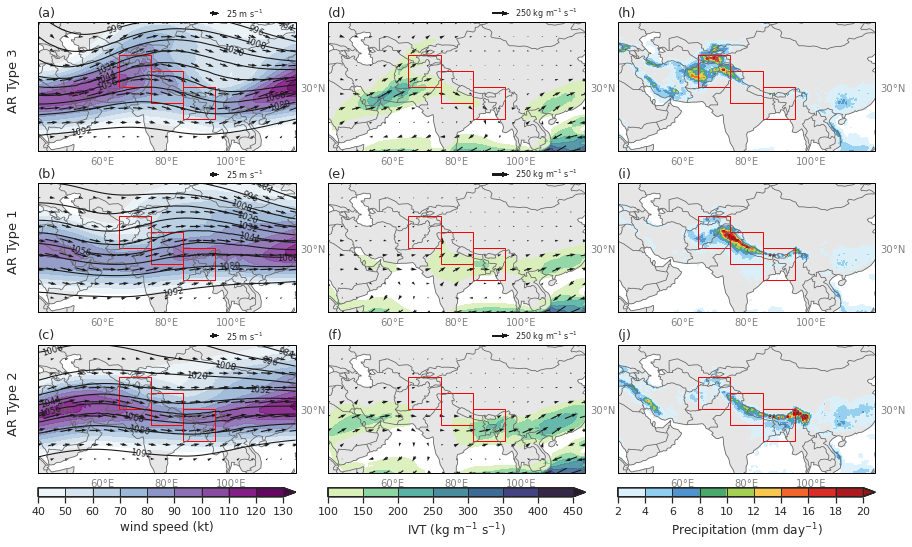

In [14]:
fig_dict = panel_dict
filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' +  'ALL_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'
nrows = fig_dict['nrows']
ncols = fig_dict['ncols']
artype_lst = fig_dict['artype_lst']
row_lbl = ['AR Type 3', 'AR Type 1', 'AR Type 2']
col_lbl1 = ['(a)', '(b)', '(c)']
col_lbl2 = ['(d)', '(e)', '(f)']
col_lbl3 = ['(h)', '(i)', '(j)']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):
    data = era_ar_comp.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values/10. #convert to decimeters
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=10, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
#     plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(col_lbl1[k], loc='left',fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    
# Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
    data = era_ar_comp.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=10, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
    ax.set_title(col_lbl2[k], loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr[nrows+nrows:], artype_lst)):
    data = era_ar_comp1.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    if plot_dict['anom'] == 'anom':
        cmap = cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None)
    if plot_dict['anom'] == 'nanom':
#         cmap = plot_dict['cmap']
        cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    prec = data.prec.values
    print(prec.min(), prec.max())
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # subtitles
    ax.set_title(col_lbl3[k], loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


In [15]:
print(hgts.min(), hgts.max())

974.91046 1096.258


In [16]:
clevs = np.arange(100, 275, 50)
clevs

cmap_data = [
             (0, 160, 255), # light blue 200-300
             (230, 220, 50), # yellow 800-900
             (250, 60, 60), # light red 2000-2100
            ]

my_cmap = make_cmap(cmap_data, bit=True)

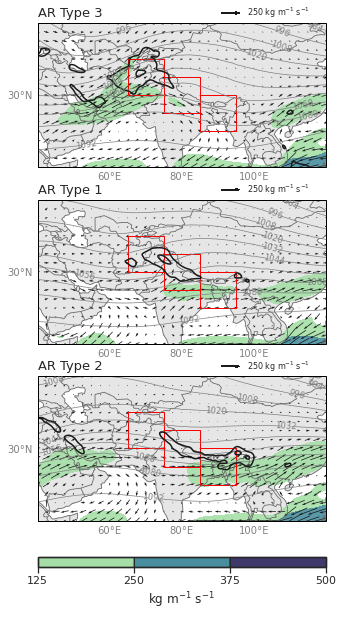

In [17]:
fig_dict = panel_dict
filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' +  'ALL_' + ar_dict['ssn'] + 'schematic.png'
nrows = 3
ncols = 1
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='7%',label_mode='',
                direction='column')

for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
    data = era_ar_comp.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    ivt_sm = gaussian_filter(ivt, sigma=1.5)
    cflevs = np.arange(125, 510, 125)
    cf = ax.contourf(lons, lats, ivt_sm, transform=datacrs,
                     levels=cflevs, cmap=cmo.deep, alpha=0.9, extend='neither') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    
    # Contour Lines
    # 250-hPa Heights
    hgts = data.H.values/10. #convert to decimeters
    clevs = np.arange(840, 1280, 12)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
    
    # Contour Lines
    # Precip
    data = era_ar_comp1.sel(ar=ar_type, lag=0)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    prec = data.prec.values
    prec_sm = gaussian_filter(prec, sigma=2.0)
    clevs = np.arange(5, 30, 10)
    cs = ax.contour(lons, lats, prec_sm, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.5)
    
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='neither')
    cb.set_label('kg m$^{-1}$ s$^{-1}$')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
